In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics


#### Use weekly average price.

In [2]:
price = pd.read_csv('../data/median_comp_price.csv')

sf_price = price[['date', 'SF_median_price']]
portland_price = price[['date', 'Portland_median_price']]
sf_price.columns = ['ds', 'y']
portland_price.columns = ['ds', 'y']



In [3]:
date_inter = 142
sf_price[:date_inter]

,ds,y
0,2015-05-03,NaN
1,2015-05-10,120.0
2,2015-05-17,124.5
3,2015-05-24,125.0
4,2015-05-31,120.0
5,2015-06-07,125.0
6,2015-06-14,125.0
7,2015-06-21,125.0
8,2015-06-28,125.0
9,2015-07-05,125.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


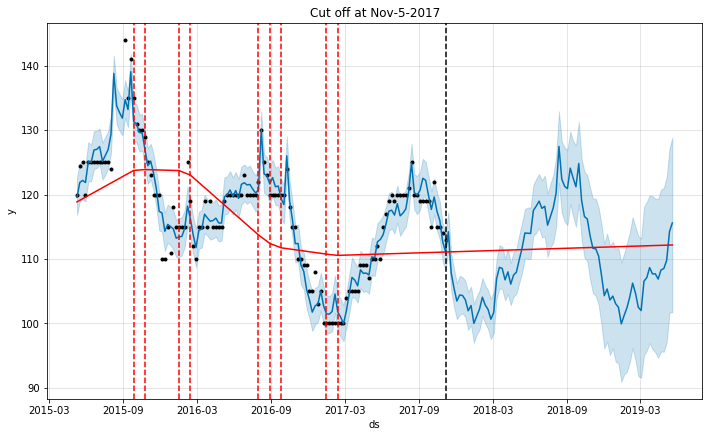

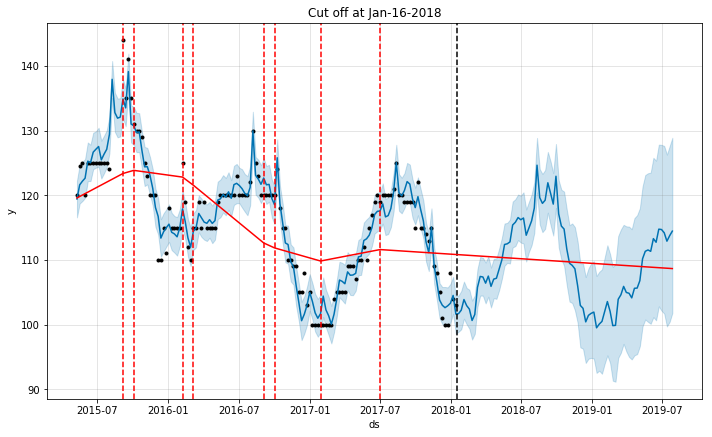

In [38]:
for date_inter in [132, 142]:

#   Outside Lands 2015: Aug 7 - Aug 9; 
#     2016: Aug 5-7; 
#     2017: Aug 11-13;
#     2018: Aug 10-12;
#     2019: Aug 9-11;

    outside_lands = pd.DataFrame({
     'holiday': 'outside lands',
    'ds': pd.to_datetime(['2019-08-11', '2018-08-12','2017-08-13',
                          '2016-08-07','2015-08-09']),
        'lower_window':0,
        'upper_window':1
    })
    
    
    
    
#     dreamforce 2018: Sept 25 - Sept 28
#     dreamforce 2017: Nov 6 - Nov 9
#     dreamforce 2016: Oct 4 - Oct 7
#     dreamforce 2015: Sept 15 - 18

    dreamforce = pd.DataFrame({
        'holiday': 'dreamforce',
        'ds': pd.to_datetime(['2019-11-24','2018-09-30', '2017-11-12', 
                              '2016-10-09', '2015-09-20']),
        'lower_window':0,
        'upper_window':1
    })
    
    holidays = pd.concat((outside_lands, dreamforce))
    
    m = Prophet(holidays = holidays, changepoint_prior_scale = 0.1, weekly_seasonality = False )
    m.add_seasonality(name = 'month', period= 30.5, fourier_order=5)
    
    m.add_country_holidays(country_name = 'US')
    
    m.fit(sf_price[1:date_inter])
    future = m.make_future_dataframe(periods = 80, freq='W')
    # future['cap'] = 250
    forecast = m.predict(future)


    fig = m.plot(forecast)
    if date_inter == 132:
        plt.axvline(x = datetime.date(2017,11,5), color = 'k', linestyle='--')
        plt.title('Cut off at Nov-5-2017')
    elif date_inter == 142:
        plt.axvline(x = datetime.date(2018,1,16), color = 'k', linestyle='--')
        plt.title('Cut off at Jan-16-2018')
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
    
#     fig2 = m.plot_components(forecast)

    forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    forecast_df.to_csv('../data/forecast_sf_{}.csv'.format(date_inter))
    
    

In [44]:
forecast[(forecast['outside lands'] + forecast['dreamforce']).abs() >0][['ds','outside lands', 'dreamforce','dreamforce_lower','dreamforce_upper']][-10:]

,ds,outside lands,dreamforce,dreamforce_lower,dreamforce_upper
13,2015-08-09,5.463902,0.000000,0.000000,0.000000
19,2015-09-20,0.000000,6.200949,6.200949,6.200949
65,2016-08-07,5.463902,0.000000,0.000000,0.000000
74,2016-10-09,0.000000,6.200949,6.200949,6.200949
118,2017-08-13,5.463902,0.000000,0.000000,0.000000
131,2017-11-12,0.000000,6.200949,6.200949,6.200949
170,2018-08-12,5.463902,0.000000,0.000000,0.000000
177,2018-09-30,0.000000,6.200949,6.200949,6.200949


In [5]:
# m.plot_components(forecast)

In [6]:
# from fbprophet.plot import plot_plotly
# import plotly.offline as py
# py.init_notebook_mode()

# fig = plot_plotly(m, forecast)  # This returns a plotly Figure
# py.iplot(fig)

In [7]:
# daily_price = pd.read_csv('../data/daily_avg_price_SF.csv')
# daily_price = daily_price[['date', 'price_float']]
# daily_price.columns = ['ds', 'y']
# daily_price['ds'] = pd.to_datetime(daily_price['ds'])

# sub_df = daily_price[(daily_price['ds'] <= pd.Timestamp(2017,11,5))]
# sub_df.tail()

In [8]:
# m_daily = Prophet(changepoint_prior_scale = 0.01)
# m_daily.add_country_holidays(country_name = 'US')

# # m.add_seasonality(name = 'quarterly', period = 12, fourier_order = 4)
# m_daily.fit(sub_df)
# future = m_daily.make_future_dataframe(periods = 365, freq='D')
# # future['cap'] = 250

In [9]:
# forecast = m_daily.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [10]:
# fig = m_daily.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), m_daily, forecast)

In [11]:
# m_daily = Prophet(changepoint_prior_scale = 0.01)
# m_daily.add_country_holidays(country_name = 'US')
# m_daily.fit(daily_price)
# cv =  cross_validation(model=m_daily, initial = '366 days', period = '90 days', horizon = '365 days')


In [12]:
# cv.tail()

In [13]:
# df_p = performance_metrics(cv)
# df_p.tail()

In [14]:
# plot_cross_validation_metric(cv, metric = 'mape')